<h3>DS 201 final project</h3>
<h4>Natural Gas Residential Price Prediction in the United States</h4>
Team 23: </br>
Craig Orman</br>
Alaina Porter</br>
Daniel Leigh</br>
All data gathered from https://www.eia.gov/naturalgas/data.php

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
import statsmodels.api as sm
#original = pd.read_csv('NG_Res_Price.csv', parse_dates=['Date'], index_col='Date')
original = pd.read_csv('NG_Res_Price.csv')

In [2]:
#reset df
df = original.copy()
df.columns = ['Date', 'Price']
print(df.isna().sum())
print(df.shape) # (487,1)
print(df.info())
print(df.head(3))
print(df.tail(3))

Date     0
Price    0
dtype: int64
(487, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487 entries, 0 to 486
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    487 non-null    object 
 1   Price   487 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.7+ KB
None
       Date  Price
0  1/1/1981   3.94
1  2/1/1981   3.99
2  3/1/1981   4.06
         Date  Price
484  5/1/2021  14.13
485  6/1/2021  17.73
486  7/1/2021  19.94


In [3]:
# Extracting date info
df.Date = pd.to_datetime(df.Date)
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df.tail()

,Date,Price,Year,Month
482,2021-03-01,10.51,2021,3
483,2021-04-01,12.25,2021,4
484,2021-05-01,14.13,2021,5
485,2021-06-01,17.73,2021,6
486,2021-07-01,19.94,2021,7


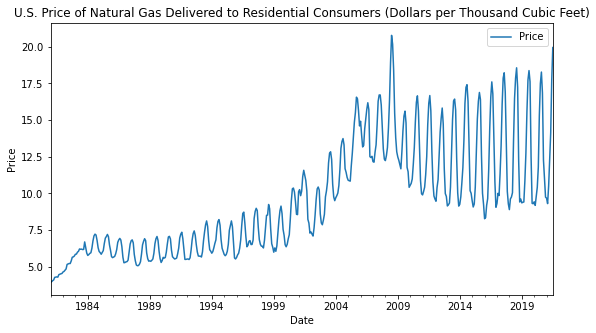

In [4]:
df.plot(x='Date', y='Price', figsize=(9,5))
plt.ylabel('Price')
plt.title("U.S. Price of Natural Gas Delivered to Residential Consumers (Dollars per Thousand Cubic Feet)")
plt.show()

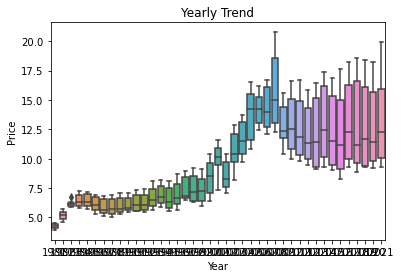

In [5]:
sns.boxplot(x=df.Year, y=df.Price)
plt.title("Yearly Trend")
plt.show()

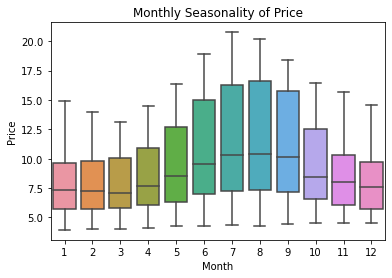

In [6]:
sns.boxplot(x=df.Month, y=df.Price)
plt.title("Monthly Seasonality of Price")
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df.Price, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
df['z_data'] = (df.Price - df.Price.rolling(window=12).mean()) / df.Price.rolling(window=12).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(12)

print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -0.939
P-value = 0.775
Critical values :
	1%: -3.4444002781824477 - The data is not stationary with 99% confidence
	5%: -2.867735576537528 - The data is not stationary with 95% confidence
	10%: -2.57007000456571 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -6.055
P-value = 0.000
Critical values :
	1%: -3.44455286264131 - The data is  stationary with 99% confidence
	5%: -2.8678027030003483 - The data is  stationary with 95% confidence
	10%: -2.5701057817594894 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -7.311
P-value = 0.000
Critical values :
	1%: -3.444965543297668 - The data is  stationary with 99% confidence
	5%: -2.8679842369272976 - The data is  stationary with 95% confidence
	10%: -2.5702025382716047 - The data is  stationary with 90% confidence


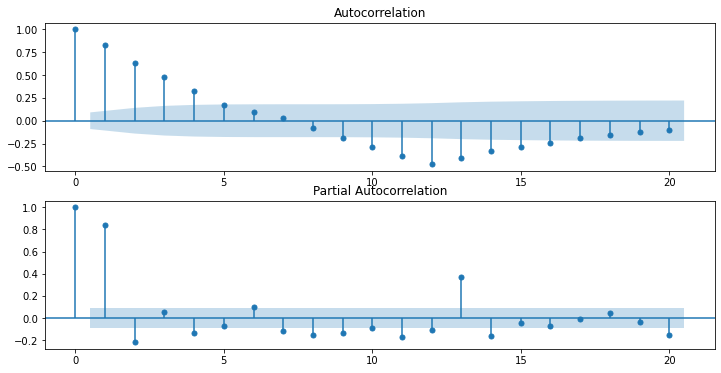

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.zp_data.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df.zp_data.dropna(), ax=ax[1], lags=20)

#We want the data to stay in the blue :(

In [9]:
#Change only this to make predictions 
months = 6

train = df.loc[0:487-months]
test = df.loc[487-months+1:487]
print(train.tail())
print(test.head())


          Date  Price  Year  Month    z_data   zp_data
477 2020-10-01  12.26  2020     10 -0.055065  0.005431
478 2020-11-01  10.99  2020     11 -0.466212  0.458736
479 2020-12-01   9.75  2020     12 -0.846769  0.072635
480 2021-01-01   9.68  2021      1 -0.878810  0.008258
481 2021-02-01   9.31  2021      2 -0.994424 -0.051359
          Date  Price  Year  Month    z_data   zp_data
482 2021-03-01  10.51  2021      3 -0.665606  0.127161
483 2021-04-01  12.25  2021      4 -0.191944  0.418317
484 2021-05-01  14.13  2021      5  0.326992  0.543395
485 2021-06-01  17.73  2021      6  1.287521  0.536349
486 2021-07-01  19.94  2021      7  1.704976  0.349226


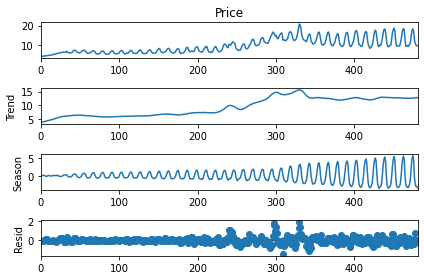

In [10]:
from statsmodels.tsa.seasonal import STL

stl = STL(train.Price, period=12)
decomposition = stl.fit()
fig = decomposition.plot()

#Y = trend+Seasonal+residual (can use addition or multiplication as needed)

                            OLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     1968.
Date:                Sat, 11 Dec 2021   Prob (F-statistic):          5.98e-172
Time:                        20:13:16   Log-Likelihood:                -860.36
No. Observations:                 482   AIC:                             1725.
Df Residuals:                     480   BIC:                             1733.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4209      0.131     33.636      0.0

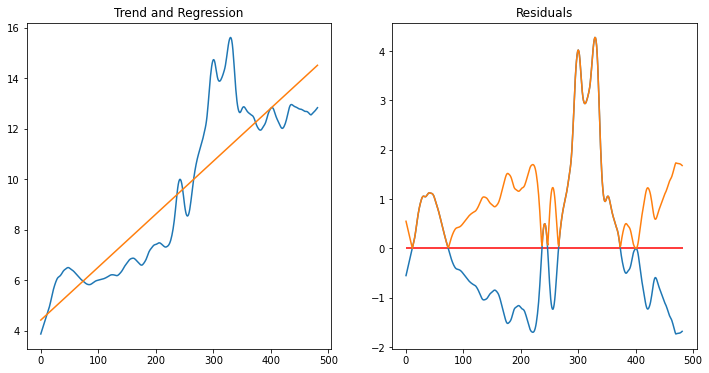

In [11]:
import statsmodels.api as sm
from statsmodels.api import OLS

x, y = np.arange(len(decomposition.trend.dropna())), decomposition.trend.dropna()
x = sm.add_constant(x)
model = OLS(y, x)
res = model.fit()
print(res.summary())
fig, ax = plt.subplots(1, 2, figsize=(12,6));
ax[0].plot(decomposition.trend.dropna().values, label='trend')
ax[0].plot([res.params.x1*i + res.params.const for i in np.arange(len(decomposition.trend.dropna()))])
ax[1].plot(res.resid.values);
ax[1].plot(np.abs(res.resid.values));
ax[1].hlines(0, 0, len(res.resid), color='r');
ax[0].set_title("Trend and Regression");
ax[1].set_title("Residuals");

#our data has high heteroskedasticity, see how the residuals get spiky as you go toward the right

In [12]:
test.Date.head()

482   2021-03-01
483   2021-04-01
484   2021-05-01
485   2021-06-01
486   2021-07-01
Name: Date, dtype: datetime64[ns]

In [15]:
def model_shown(pred, pred2, test, months):
    prediction = pd.DataFrame()
    prediction['Model1'] = pred
    prediction['Model2'] = pred2
    prediction['Actual'] = test.Price.head(months)
    prediction['Year'] = test.Year.head(months)
    prediction['Month'] = test.Month.head(months)
    prediction['Date'] = test.Date
    for x in prediction.Model2:
        prediction.Model2 +=0.25
        #Adding a constant for increased accuracy
    print(prediction)
    prediction.plot(y=['Model1', 'Model2', 'Actual'], x='Date')
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Predicted and actual gas prices")
    plt.show()
    r = r2_score(test.Price, pred)
    rows = 5
    columns = 1
    adjrsquared = 1-(1-r)* (rows-1)/(rows-columns-1)
    adjrsquared 
    print("R^2", r.round(3))
    print("Adjusted R^2", adjrsquared.round(3))
    print("Testing RMSE", np.sqrt(metrics.mean_squared_error(test.Price, pred)).round(3))
    print("Testing MAE", metrics.mean_absolute_error(test.Price, pred).round(3))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


          Date  Price  Year  Month    z_data   zp_data
475 2020-08-01  18.27  2020      8  1.578205 -0.002892
476 2020-09-01  16.85  2020      9  1.235608 -0.109244
477 2020-10-01  12.26  2020     10 -0.055065  0.005431
478 2020-11-01  10.99  2020     11 -0.466212  0.458736
479 2020-12-01   9.75  2020     12 -0.846769  0.072635
480 2021-01-01   9.68  2021      1 -0.878810  0.008258
481 2021-02-01   9.31  2021      2 -0.994424 -0.051359
Predicted
        Model1     Model2  Actual  Year  Month       Date
482  10.038783  11.288783   10.51  2021      3 2021-03-01
483  11.049135  12.299135   12.25  2021      4 2021-04-01
484  13.235286  14.485286   14.13  2021      5 2021-05-01
485  16.838787  18.088787   17.73  2021      6 2021-06-01
486  18.809816  20.059816   19.94  2021      7 2021-07-01


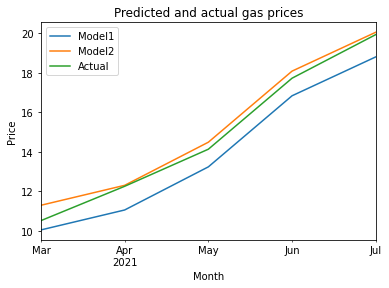

R^2 0.925
Adjusted R^2 0.9
Testing RMSE 0.952
Testing MAE 0.918


In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train.Price, trend="add", seasonal="add", seasonal_periods=12)
damp_model = ExponentialSmoothing(train.Price, trend="add", seasonal="add", seasonal_periods=12)

fit = model.fit()
pred = fit.forecast(months-1)
damp_fit = damp_model.fit()
damp_pred = damp_fit.forecast(months-1)
print(train.tail(months+1))
print("Predicted")
model_shown(pred, damp_pred, test, months)

In [20]:
df.tail(3)

,Date,Price,Year,Month,z_data,zp_data
484,2021-05-01,14.13,2021,5,0.326992,0.543395
485,2021-06-01,17.73,2021,6,1.287521,0.536349
486,2021-07-01,19.94,2021,7,1.704976,0.349226


Predicted in January 22
     Final       Date
487  20.27 2021-07-01
488  18.76 2021-08-01
489  13.95 2021-09-01
490  11.71 2021-10-01
491  10.72 2021-11-01
492  10.69 2021-12-01
493  10.55 2022-01-01


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Text(0.5, 1.0, 'Predicted Gas Price for 2022')

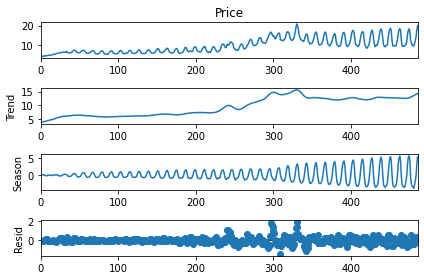

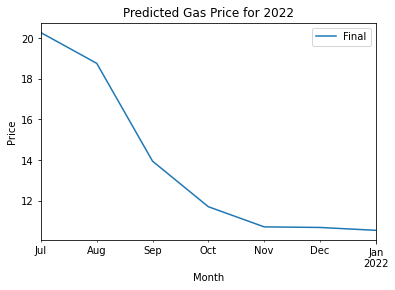

In [26]:
#prediction for next January 2021
stl_final = STL(df.Price, period=12)
decomposition_final = stl_final.fit()
fig_final = decomposition_final.plot()

model_final = ExponentialSmoothing(df.Price, trend="add", seasonal="add", seasonal_periods=12)

fit_final = model_final.fit()
pred_final = fit_final.forecast(7)
prediction_final = pd.DataFrame()

prediction_final['Final'] = pred_final.round(2)
prediction_final['Date'] = pd.date_range(start="2021-07-01", periods=7, freq='MS')
print("Predicted in January 22")

print(prediction_final)
prediction_final.plot(y='Final', x='Date')
plt.xlabel("Month")
plt.ylabel("Price")
plt.title("Predicted Gas Price for 2022")